<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/DMR_Multilayered_3DBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This demo solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) multilayered structures, (2) membrane permeability, (3) pure homogeneous Neumann 

# Copyright (C) 2017 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2017-11-18

# This demo is maintained by Van-Dang Nguyen
# Please report problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [19]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


# Setup phase-function for multilyered structures

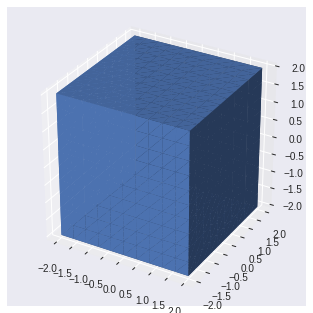

In [24]:
p0=Point(-2, -2, -2);
p1=Point(2, 2, 2);
mesh=BoxMesh(p0, p1, 10, 10, 10);

plot(mesh)


gdim = mesh.geometry().dim()


V_DG = FunctionSpace(mesh, 'DG', 0)
dofmap_DG = V_DG.dofmap()
phase = Function(V_DG)
cellmarker = MeshFunction("size_t", mesh, mesh.topology().dim())

for cell in cells(mesh):
    p = cell.midpoint();
    if abs(p.y())<0.8 and abs(p.x())<0.8:
        phase.vector()[dofmap_DG.cell_dofs(cell.index())] = 1;
        cellmarker[cell.index()] = 1;

# plot(mesh);
# plot(cellmarker, cmap="coolwarm");
# plot(phase, cmap="coolwarm");

File("phase.pvd")<<phase

mesh0 = SubMesh(mesh, cellmarker, 0)
mesh1 = SubMesh(mesh, cellmarker, 1)

#plot(mesh0)

# Define parameters

In [0]:
bvalue = 0;             # bvalue
delta, Delta = 40000, 40000 # PGSE sequence
g0, g1, g2 = 1, 1, 1;       # gradient direction
theta = 0.5;                # theta=0.5: midpoint method
K = 3e-3;                   # Diffusion coefficient
kappa = 1e-3                # Permeability
nskip = 5;                  # Output frequency (for visualization only)
porder = 1;                 # order of basis functions of FEM
Nsteps = 200;               # number of time intervals

# Solve the Bloch-Torrey equation

t: 0.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 0.00%
t: 2000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 2.49%
t: 4000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 4.98%
t: 6000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 7.46%
t: 8000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 9.95%
t: 10000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 12.44%
t: 12000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 14.93%
t: 14000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 17.41%
t: 16000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 19.90%
t: 18000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 22.39%
t: 20000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 24.88%
t: 22000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 27.36%
t: 24000.000000  T: 80000.0 dt:400.0 gnorm: 0.000000e+00 Completed 29.85%
t: 26000.000000  T: 80000.0 dt:400.0 gnorm: 0.00000

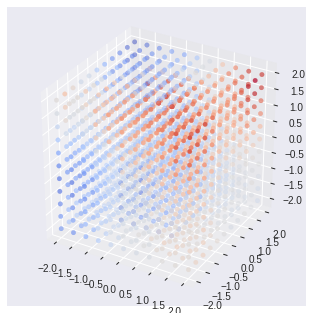

In [27]:
if (Delta-delta/3.0<=0):
    print('Check time sequence!');
    exit(0);
gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
t, T = 0, Delta+delta;

#################################################################################
# FUNCTION SPACES
if dolfin_version=='1.6.0':
    V = FunctionSpace(mesh , "CG", porder);
    W = MixedFunctionSpace([V, V, V, V])
else:
    # For FEniCS 2016, 2017
    Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
    TH = MixedElement([Ve,Ve,Ve,Ve])
    V = FunctionSpace(mesh,Ve);
    W = FunctionSpace(mesh, TH)

v = TestFunction(W)
v0r, v0i, v1r, v1i = v[0], v[1], v[2], v[3]

w = TrialFunction(W);
u0r, u0i, u1r, u1i = w[0], w[1], w[2], w[3]
#################################################################################

#################################################################################
# Initial conditions
one = Function(V);
one.vector()[:] = 1.0;
u_0 = Function(W);
assign(u_0.sub(0), one)
assign(u_0.sub(2), one)
u0r_0, u0i_0, u1r_0, u1i_0 = u_0[0], u_0[1], u_0[2], u_0[3]
#################################################################################

if (gdim==2):
  GX=Expression("x[0]*g0+x[1]*g1", g0=g0, g1=g1, domain=mesh, degree=3);
if (gdim==3):
  GX=Expression("x[0]*g0+x[1]*g1+x[2]*g2", g0=g0, g1=g1, g2=g2, domain=mesh, degree=3);

#################################
## output files 
file_u0r = File("results/u0r.pvd")
file_u0i = File("results/u0i.pvd")
file_u1r = File("results/u1r.pvd")
file_u1i = File("results/u1i.pvd")
#################################

def FuncF(ft, gnorm, GX, ur, ui, vr, vi, K):
    Fr = ft*gnorm*GX*ui*vr - K*inner(grad(ur), grad(vr))
    Fi = - ft*gnorm*GX*ur*vi - K*inner(grad(ui), grad(vi))
    return Fr + Fi
  
def icondition(kappa, u0rm, u1rm, v0r, v1r, u0im, u1im, v0i, v1i):
    F_bcr = kappa*(u0rm-u1rm)*(v0r-v1r)
    F_bci = kappa*(u0im-u1im)*(v0i-v1i)
    return F_bcr + F_bci

def SubMeshSave(ur, ui, file_ur, file_ui, mesh, n, stepcounter, dolfin_version):
  if dolfin_version=='1.6.0':
    V = FunctionSpace(mesh, "CG", porder)
  else:
    # For FEniCS 2016, 2017
    Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
    V = FunctionSpace(mesh, Ve)
  if stepcounter % n == 0:
    ur_p = project(ur, V);
    ui_p = project(ui, V);
    ur_p.rename("Real", "label");
    ui_p.rename("Imag", "label");
    file_ur << ur_p;
    file_ui << ui_p;

def ieval(u,omega, phase):
  if omega==1:
    return u('+')*phase('+') + u('-')*phase('-');
  if omega==0:
    return u('+')*(1.-phase('+')) + u('-')*(1.-phase('-'))                      
  
def FT(t, delta, Delta):
    ft1 = 1.0*(t>=0 and t<delta) 
    ft2 = -1.0*(t>=Delta and t<=Delta+delta);
    return ft1 + ft2;  
  
stepcounter = 0;

def ThetaMethod_L(ft, gnorm, GX, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k, kappa, K, theta, phase):
    L0 = (u0r_0/k*v0r + u0i_0/k*v0i+(1-theta)*FuncF(ft, gnorm, GX, u0r_0, u0i_0, v0r, v0i, K))*(1-phase)*dx
    L1 = (u1r_0/k*v1r +u1i_0/k*v1i+(1-theta)*FuncF(ft, gnorm, GX, u1r_0, u1i_0, v1r, v1i, K))*phase*dx
    L_bc = avg((1-theta)*icondition(kappa, u0r_0, u1r_0, v0r, v1r, u0i_0, u1i_0, v0i, v1i))*abs(jump(phase))*dS;
    return L0+L1-L_bc


def ThetaMethod_a(ft, gnorm, GX, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k,kappa, K, theta, phase):
    a0 = (u0r/k*v0r   + u0i/k*v0i  -theta*FuncF(ft, gnorm, GX, u0r  , u0i  , v0r, v0i, K))*(1-phase)*dx
    a1 = (u1r/k*v1r   + u1i/k*v1i  -theta*FuncF(ft, gnorm, GX, u1r  , u1i  , v1r, v1i, K))*phase*dx
    a_bc = avg(  (theta*icondition(kappa, u0r  , u1r  , v0r, v1r, u0i  , u1i  , v0i, v1i)))*abs(jump(phase))*dS;
    return a0+a1+a_bc


def NoTimeMatrices(u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, K, GX, kappa, theta, phase):
    m0 = (u0r*v0r   + u0i*v0i)*(1-phase)*dx
    m1 = (u1r*v1r   + u1i*v1i)*phase*dx
    M = assemble(m0+m1);
        
    j0 = -GX*(u0i*v0r   - u0r*v0i)*(1-phase)*dx
    j1 = -GX*(u1i*v1r   - u1r*v1i)*phase*dx
    J = assemble(j0+j1);    
    s0 = K*( inner(grad(u0r), grad(v0r)) + inner(grad(u0i), grad(v0i)) )*(1-phase)*dx
    s1 = K*( inner(grad(u1r), grad(v1r)) + inner(grad(u1i), grad(v1i)) )*phase*dx
    S = assemble(s0+s1)

    im = avg(  icondition(kappa, u0r  , u1r  , v0r, v1r, u0i  , u1i  , v0i, v1i) )*abs(jump(phase))*dS;
    I = assemble(im)
    
    M.ident_zeros();
    
    return M, J, S, I

def ThetaMethod_A(ft, gnorm, theta, k, M, J, S, I):
    return 1./k*M + ft*gnorm*theta*J + theta*S + theta*I

# Theta method

stepcounter = 0;

k = T/Nsteps; # Time-step size

hmin = mesh.hmin();

M, J, S, I = NoTimeMatrices(u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, K, GX, kappa, theta, phase);

while t < T: # Time-stepping loop
    if stepcounter % nskip == 0:
        print('t: %f '%t, 'T: %.1f'%T, 'dt:%.1f'%k,'gnorm: %e'%gnorm,'Completed %.2f%%'%(float(t)/float(T+k)*100.0));

    ft = FT(t, delta, Delta);

    L = ThetaMethod_L(ft, gnorm, GX, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k, kappa, K, theta, phase);
    # a = ThetaMethod_a(ft, gnorm, GX, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k,kappa, K, theta, phase);
    # a = a + 1e-6*(u0r*v0r+u0i*v0i)*theta*dx + 1e-6*(u1r*v1r+u1i*v1i)*(1-theta)*dx
    A = ThetaMethod_A(ft, gnorm, theta, k, M, J, S, I);
    # A = assemble(a);
    b = assemble(L);

    # print J.is_symmetric(1e-10);
    # stop
 
    u = Function(W)
    solve(A,u.vector(),b, "gmres", "ilu");
    
    u0r_0, u0i_0, u1r_0, u1i_0 = split(u)
    
    SubMeshSave(u0r_0, u0i_0, file_u0r, file_u0i, mesh0, nskip, stepcounter, dolfin_version);
    SubMeshSave(u1r_0, u1i_0, file_u1r, file_u1i, mesh1, nskip, stepcounter, dolfin_version);
    
    t += k;
    stepcounter += 1;

signal = assemble((phase*u1r_0+(1-phase)*u0r_0)*dx)/assemble(one*dx);
print('b:',bvalue, 'Signal: %.7e'%signal,'kappa: %.3e'%kappa,', dt:',k,', hmin:',hmin)


V0 = FunctionSpace(mesh0,Ve);
V1 = FunctionSpace(mesh1,Ve);
u0r_0p = project(u0r_0,V0)
u1r_0p = project(u1r_0,V1)
plot(u0r_0p, cmap="coolwarm")
plot(u1r_0p, cmap="coolwarm")

